In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import skew, kurtosis, norm, probplot
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

# Загрузка данных
df = pd.read_csv('../datasets/teen_phone_addiction_dataset.csv')

N = 9
cols = ['Daily_Usage_Hours', 'Sleep_Hours', 'Exercise_Hours', 
        'Screen_Time_Before_Bed', 'Time_on_Social_Media', 
        'Time_on_Gaming', 'Time_on_Education']
selected_col = cols[N % 7]
print(f"Выбранный столбец для анализа: {selected_col}")

data = df[selected_col].dropna()

Выбранный столбец для анализа: Exercise_Hours


=== СТАТИСТИЧЕСКИЕ ХАРАКТЕРИСТИКИ ===
Среднее: 1.0407
Дисперсия: 0.5397
Мода: 0.0
Медиана: 1.0000
Квантили (0.25, 0.5, 0.75): [0.5 1.  1.5]
Асимметрия: 0.4384
Эксцесс: -0.2591
Интерквартильный размах: 1.0000


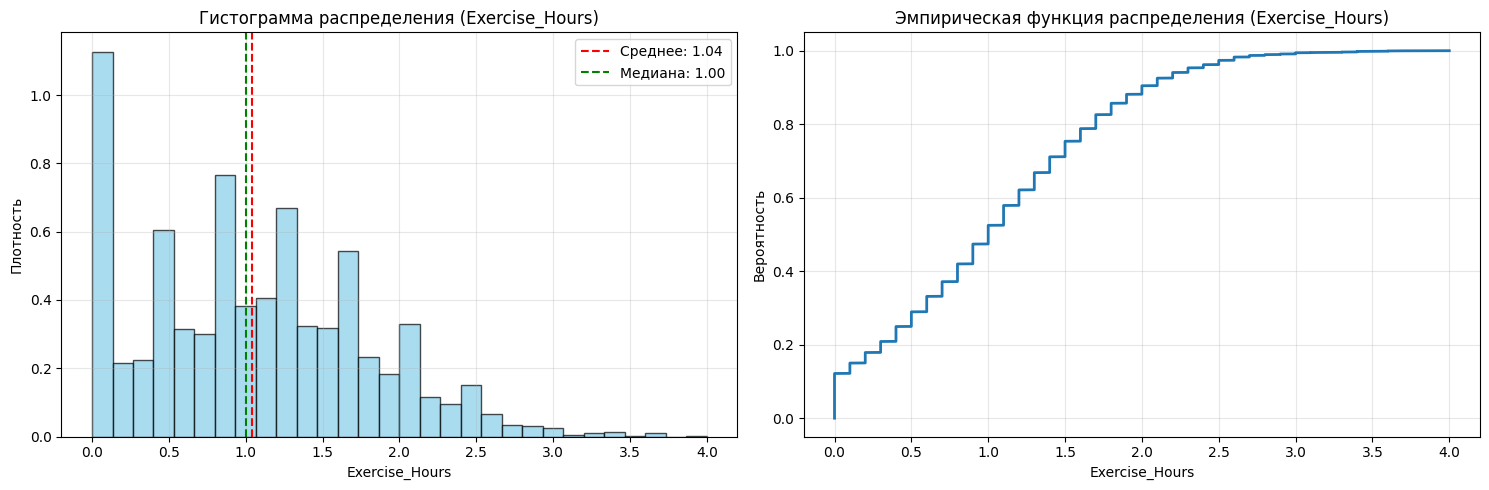

In [3]:
# Расчет статистических характеристик
mean_val = data.mean()
variance_val = data.var()
mode_val = data.mode().iloc[0] if not data.mode().empty else None
median_val = data.median()
quantiles = data.quantile([0.25, 0.5, 0.75])
skewness_val = skew(data)
kurtosis_val = kurtosis(data) 
iqr_val = quantiles[0.75] - quantiles[0.25]

print("=== СТАТИСТИЧЕСКИЕ ХАРАКТЕРИСТИКИ ===")
print(f"Среднее: {mean_val:.4f}")
print(f"Дисперсия: {variance_val:.4f}")
print(f"Мода: {mode_val}")
print(f"Медиана: {median_val:.4f}")
print(f"Квантили (0.25, 0.5, 0.75): {quantiles.values}")
print(f"Асимметрия: {skewness_val:.4f}")
print(f"Эксцесс: {kurtosis_val:.4f}")
print(f"Интерквартильный размах: {iqr_val:.4f}")

# Построение графиков
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Гистограммы
axes[0].hist(data, bins=30, density=True, alpha=0.7, color='skyblue', edgecolor='black')
axes[0].axvline(mean_val, color='red', linestyle='--', label=f'Среднее: {mean_val:.2f}')
axes[0].axvline(median_val, color='green', linestyle='--', label=f'Медиана: {median_val:.2f}')
axes[0].set_xlabel(selected_col)
axes[0].set_ylabel('Плотность')
axes[0].set_title(f'Гистограмма распределения ({selected_col})')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Эмпирическая функция распределения
sorted_data = np.sort(data)
y_vals = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
axes[1].plot(sorted_data, y_vals, linewidth=2)
axes[1].set_xlabel(selected_col)
axes[1].set_ylabel('Вероятность')
axes[1].set_title(f'Эмпирическая функция распределения ({selected_col})')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [4]:
# Выводы по разделу I
print("\nВЫВОДЫ ПО ИСХОДНЫМ ДАННЫМ:")
print(f"1. Распределение имеет асимметрию {skewness_val:.4f} и эксцесс {kurtosis_val:.4f}")
print("2. Разница между средним и медианой указывает на наличие выбросов")
print("3. Гистограмма показывает форму распределения данных")


ВЫВОДЫ ПО ИСХОДНЫМ ДАННЫМ:
1. Распределение имеет асимметрию 0.4384 и эксцесс -0.2591
2. Разница между средним и медианой указывает на наличие выбросов
3. Гистограмма показывает форму распределения данных


=== ПРОВЕРКА НА НОРМАЛЬНОСТЬ ===
Критерий хи-квадрат: 570.0734
Критическое значение (α=0.05, df=9): 16.9190
Гипотеза нормальности (хи-квадрат): отвергается

Критерий асимметрии: Z = 9.8082
Критерий эксцесса: Z = -2.8988
Критическое значение Z (α=0.05): 1.9600
Гипотеза нормальности (асимметрия): отвергается
Гипотеза нормальности (эксцесс): отвергается


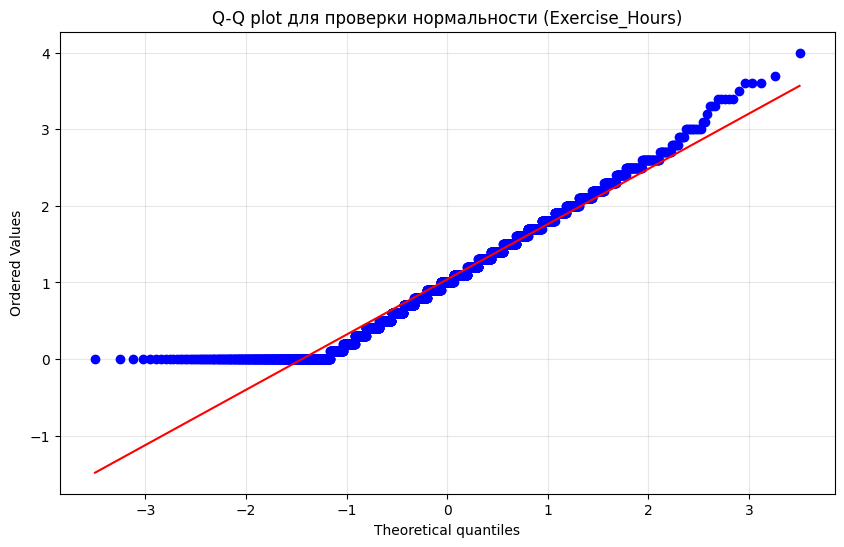


ОБЩИЙ ВЫВОД: Данные НЕ являются нормальными


In [5]:
# Критерий хи-квадрат (реализация вручную)
def chi_square_normality_test(data, alpha=0.05):
    # Разбиение на интервалы по правилу Стёрджеса
    k = int(1 + 3.322 * np.log10(len(data)))
    
    # Создание интервалов
    min_val, max_val = data.min(), data.max()
    bins = np.linspace(min_val, max_val, k + 1)
    
    # Наблюдаемые частоты
    observed, _ = np.histogram(data, bins=bins)
    
    # Ожидаемые частоты для нормального распределения
    mu, sigma = data.mean(), data.std()
    expected = []
    for i in range(len(bins) - 1):
        prob = norm.cdf(bins[i+1], mu, sigma) - norm.cdf(bins[i], mu, sigma)
        expected.append(prob * len(data))
    
    # Критерий хи-квадрат
    chi_square = np.sum((observed - expected)**2 / expected)
    
    # Степени свободы
    df = k - 3  # k интервалов - 3 параметра (μ, σ, и оценка по выборке)
    
    # Критическое значение
    critical_value = stats.chi2.ppf(1 - alpha, df)
    
    return chi_square, critical_value, df, chi_square < critical_value

# Применение критерия хи-квадрат
chi_sq, crit_val, dof, is_normal_chi = chi_square_normality_test(data)

print("=== ПРОВЕРКА НА НОРМАЛЬНОСТЬ ===")
print(f"Критерий хи-квадрат: {chi_sq:.4f}")
print(f"Критическое значение (α=0.05, df={dof}): {crit_val:.4f}")
print(f"Гипотеза нормальности (хи-квадрат): {'не отвергается' if is_normal_chi else 'отвергается'}")

# Критерий асимметрии и эксцесса
def skewness_kurtosis_test(data, alpha=0.05):
    n = len(data)
    skewness = stats.skew(data)
    kurt = stats.kurtosis(data, fisher=False)  # Fisher=False для обычного эксцесса
    
    # Стандартные ошибки
    se_skew = np.sqrt(6 * n * (n - 1) / ((n - 2) * (n + 1) * (n + 3)))
    se_kurt = np.sqrt(24 * n * (n - 1)**2 / ((n - 3) * (n - 2) * (n + 3) * (n + 5)))
    
    # Z-статистики
    z_skew = skewness / se_skew
    z_kurt = (kurt - 3) / se_kurt  # 3 - эксцесс нормального распределения
    
    # Критические значения (двусторонний тест)
    z_critical = stats.norm.ppf(1 - alpha/2)
    
    skew_normal = abs(z_skew) < z_critical
    kurt_normal = abs(z_kurt) < z_critical
    
    return z_skew, z_kurt, z_critical, skew_normal, kurt_normal

z_skew, z_kurt, z_crit, skew_normal, kurt_normal = skewness_kurtosis_test(data)

print(f"\nКритерий асимметрии: Z = {z_skew:.4f}")
print(f"Критерий эксцесса: Z = {z_kurt:.4f}")
print(f"Критическое значение Z (α=0.05): {z_crit:.4f}")
print(f"Гипотеза нормальности (асимметрия): {'не отвергается' if skew_normal else 'отвергается'}")
print(f"Гипотеза нормальности (эксцесс): {'не отвергается' if kurt_normal else 'отвергается'}")

# Q-Q plot
plt.figure(figsize=(10, 6))
probplot(data, dist="norm", plot=plt)
plt.title(f'Q-Q plot для проверки нормальности ({selected_col})')
plt.grid(True, alpha=0.3)
plt.show()

# Общий вывод о нормальности
is_normal_overall = is_normal_chi and skew_normal and kurt_normal
print(f"\nОБЩИЙ ВЫВОД: Данные {'являются нормальными' if is_normal_overall else 'НЕ являются нормальными'}")

Лучшее преобразование: Бокс-Кокс (асимметрия = 0.0351)


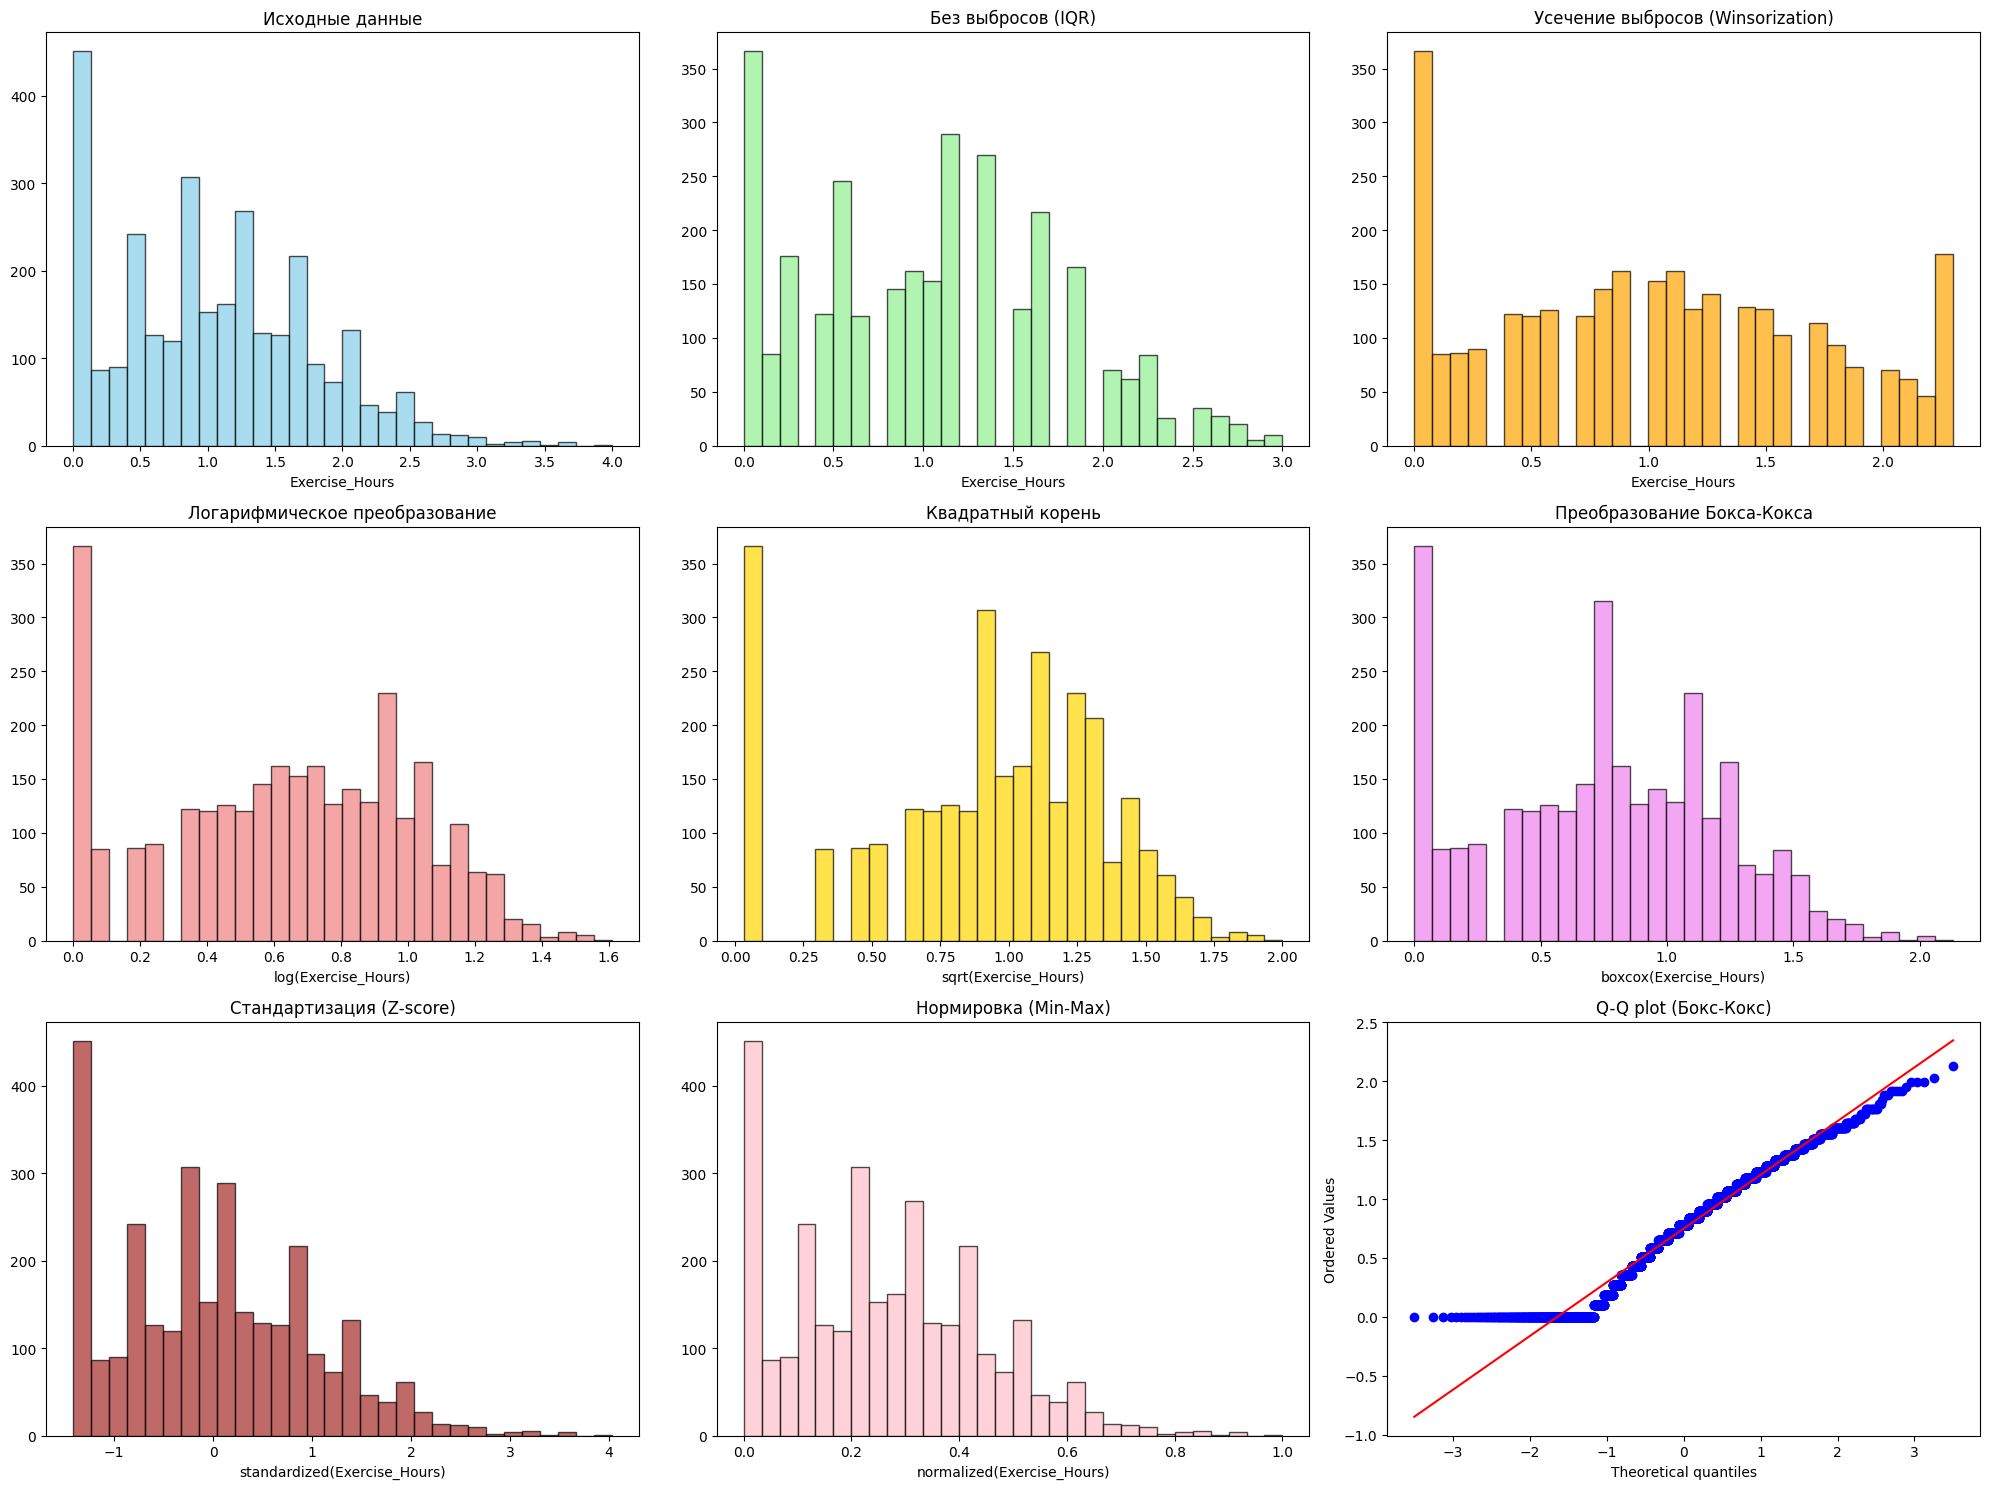


=== АНАЛИЗ ПОСЛЕ ОБРАБОТКИ ДАННЫХ ===
Среднее: 0.7494
Дисперсия: 0.2146
Асимметрия: -0.0351
Эксцесс: -0.7952

Проверка нормальности после обработки:
Хи-квадрат: не нормальные
Асимметрия: нормальные
Эксцесс: не нормальные
ОБЩИЙ ВЫВОД после обработки: Данные остались ненормальными


In [11]:
# Создание копии данных для обработки
data_processed = data.copy()

# 1. Удаление выбросов по методу IQR
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

data_no_outliers = data[(data >= lower_bound) & (data <= upper_bound)]

# 2. Усечение выбросов (Winsorization)
data_winsorized = winsorize(data, limits=[0.05, 0.05])

# 3. Логарифмическое преобразование 
data_log = np.log1p(data)
# 4. Квадратный корень
data_sqrt = np.sqrt(data - data.min() + 0.001)  # Сдвиг для избежания отрицательных значений

# 5. Преобразование Бокса-Кокса
def box_cox_transform(data):
    # Box-Cox требует положительных значений
    if np.min(data) <= 0:
        data_positive = data - np.min(data) + 1
    else:
        data_positive = data
    
    # Находим оптимальный параметр λ
    transformed_data, lambda_val = stats.boxcox(data_positive)
    return transformed_data, lambda_val

data_boxcox, lambda_val = box_cox_transform(data)

# 6. Стандартизация (Z-score нормализация)
scaler_standard = StandardScaler()
data_standardized = scaler_standard.fit_transform(data.values.reshape(-1, 1)).flatten()

# 7. Нормировка (Min-Max scaling)
scaler_minmax = MinMaxScaler()
data_normalized = scaler_minmax.fit_transform(data.values.reshape(-1, 1)).flatten()

# Сравнение методов преобразования
fig, axes = plt.subplots(3, 3, figsize=(20, 15))

# Исходные данные
axes[0, 0].hist(data, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Исходные данные')
axes[0, 0].set_xlabel(selected_col)

# Без выбросов (IQR)
axes[0, 1].hist(data_no_outliers, bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
axes[0, 1].set_title('Без выбросов (IQR)')
axes[0, 1].set_xlabel(selected_col)

# Усечение выбросов
axes[0, 2].hist(data_winsorized, bins=30, alpha=0.7, color='orange', edgecolor='black')
axes[0, 2].set_title('Усечение выбросов (Winsorization)')
axes[0, 2].set_xlabel(selected_col)

# Логарифмирование
axes[1, 0].hist(data_log, bins=30, alpha=0.7, color='lightcoral', edgecolor='black')
axes[1, 0].set_title('Логарифмическое преобразование')
axes[1, 0].set_xlabel('log(' + selected_col + ')')

# Квадратный корень
axes[1, 1].hist(data_sqrt, bins=30, alpha=0.7, color='gold', edgecolor='black')
axes[1, 1].set_title('Квадратный корень')
axes[1, 1].set_xlabel('sqrt(' + selected_col + ')')

# Бокс-Кокс
axes[1, 2].hist(data_boxcox, bins=30, alpha=0.7, color='violet', edgecolor='black')
axes[1, 2].set_title('Преобразование Бокса-Кокса')
axes[1, 2].set_xlabel('boxcox(' + selected_col + ')')

# Стандартизация
axes[2, 0].hist(data_standardized, bins=30, alpha=0.7, color='brown', edgecolor='black')
axes[2, 0].set_title('Стандартизация (Z-score)')
axes[2, 0].set_xlabel('standardized(' + selected_col + ')')

# Нормировка
axes[2, 1].hist(data_normalized, bins=30, alpha=0.7, color='pink', edgecolor='black')
axes[2, 1].set_title('Нормировка (Min-Max)')
axes[2, 1].set_xlabel('normalized(' + selected_col + ')')

# Сравнение методов преобразования
transformations = {
    'Исходные': data,
    'Без выбросов (IQR)': data_no_outliers,
    'Усечение выбросов': data_winsorized,
    'Логарифм': data_log,
    'Квадратный корень': data_sqrt,
    'Бокс-Кокс': data_boxcox,
    'Стандартизация': data_standardized,
    'Нормировка': data_normalized
}

best_transform = None
min_skewness = float('inf')

for name, transformed_data in transformations.items():
    # Проверяем, что данные не пустые и содержат достаточно значений
    if len(transformed_data) > 10 and not np.all(np.isnan(transformed_data)):
        # Убираем NaN значения для расчета асимметрии
        clean_data = transformed_data[~np.isnan(transformed_data)]
        if len(clean_data) > 10:
            try:
                current_skew = abs(stats.skew(clean_data))
                if current_skew < min_skewness:
                    min_skewness = current_skew
                    best_transform = (name, clean_data)
            except:
                continue

print(f"Лучшее преобразование: {best_transform[0]} (асимметрия = {min_skewness:.4f})")

# Q-Q plot для лучшего преобразования
if best_transform is not None:
    probplot(best_transform[1], dist="norm", plot=axes[2, 2])
    axes[2, 2].set_title(f'Q-Q plot ({best_transform[0]})')
else:
    axes[2, 2].text(0.5, 0.5, 'Не удалось построить Q-Q plot', 
                   horizontalalignment='center', verticalalignment='center',
                   transform=axes[2, 2].transAxes)
    axes[2, 2].set_title('Q-Q plot (ошибка)')

plt.tight_layout()
plt.show()

# Применяем лучшее преобразование
if best_transform is not None:
    data_processed = best_transform[1]
else:
    data_processed = data
    print("Не удалось выбрать лучшее преобразование, используются исходные данные")

# Повторяем анализ для обработанных данных
print("\n=== АНАЛИЗ ПОСЛЕ ОБРАБОТКИ ДАННЫХ ===")

# Характеристики обработанных данных
if len(data_processed) > 0 and not np.all(np.isnan(data_processed)):
    mean_processed = np.nanmean(data_processed)
    variance_processed = np.nanvar(data_processed)
    skewness_processed = stats.skew(data_processed[~np.isnan(data_processed)])
    kurtosis_processed = kurtosis(data_processed[~np.isnan(data_processed)])
    
    print(f"Среднее: {mean_processed:.4f}")
    print(f"Дисперсия: {variance_processed:.4f}")
    print(f"Асимметрия: {skewness_processed:.4f}")
    print(f"Эксцесс: {kurtosis_processed:.4f}")
    
    # Проверка на нормальность для обработанных данных
    if len(data_processed[~np.isnan(data_processed)]) > 10:
        chi_sq_proc, crit_val_proc, dof_proc, is_normal_chi_proc = chi_square_normality_test(data_processed)
        z_skew_proc, z_kurt_proc, z_crit_proc, skew_normal_proc, kurt_normal_proc = skewness_kurtosis_test(data_processed)
        
        print(f"\nПроверка нормальности после обработки:")
        print(f"Хи-квадрат: {'нормальные' if is_normal_chi_proc else 'не нормальные'}")
        print(f"Асимметрия: {'нормальные' if skew_normal_proc else 'не нормальные'}")
        print(f"Эксцесс: {'нормальные' if kurt_normal_proc else 'не нормальные'}")
        
        is_normal_after = is_normal_chi_proc and skew_normal_proc and kurt_normal_proc
        print(f"ОБЩИЙ ВЫВОД после обработки: Данные {'стали нормальными' if is_normal_after else 'остались ненормальными'}")
    else:
        print("Недостаточно данных для проверки нормальности после обработки")
else:
    print("Обработанные данные пусты или содержат только NaN значения")

Уникальные значения School_Grade: ['9th' '7th' '11th' '12th' '10th' '8th']


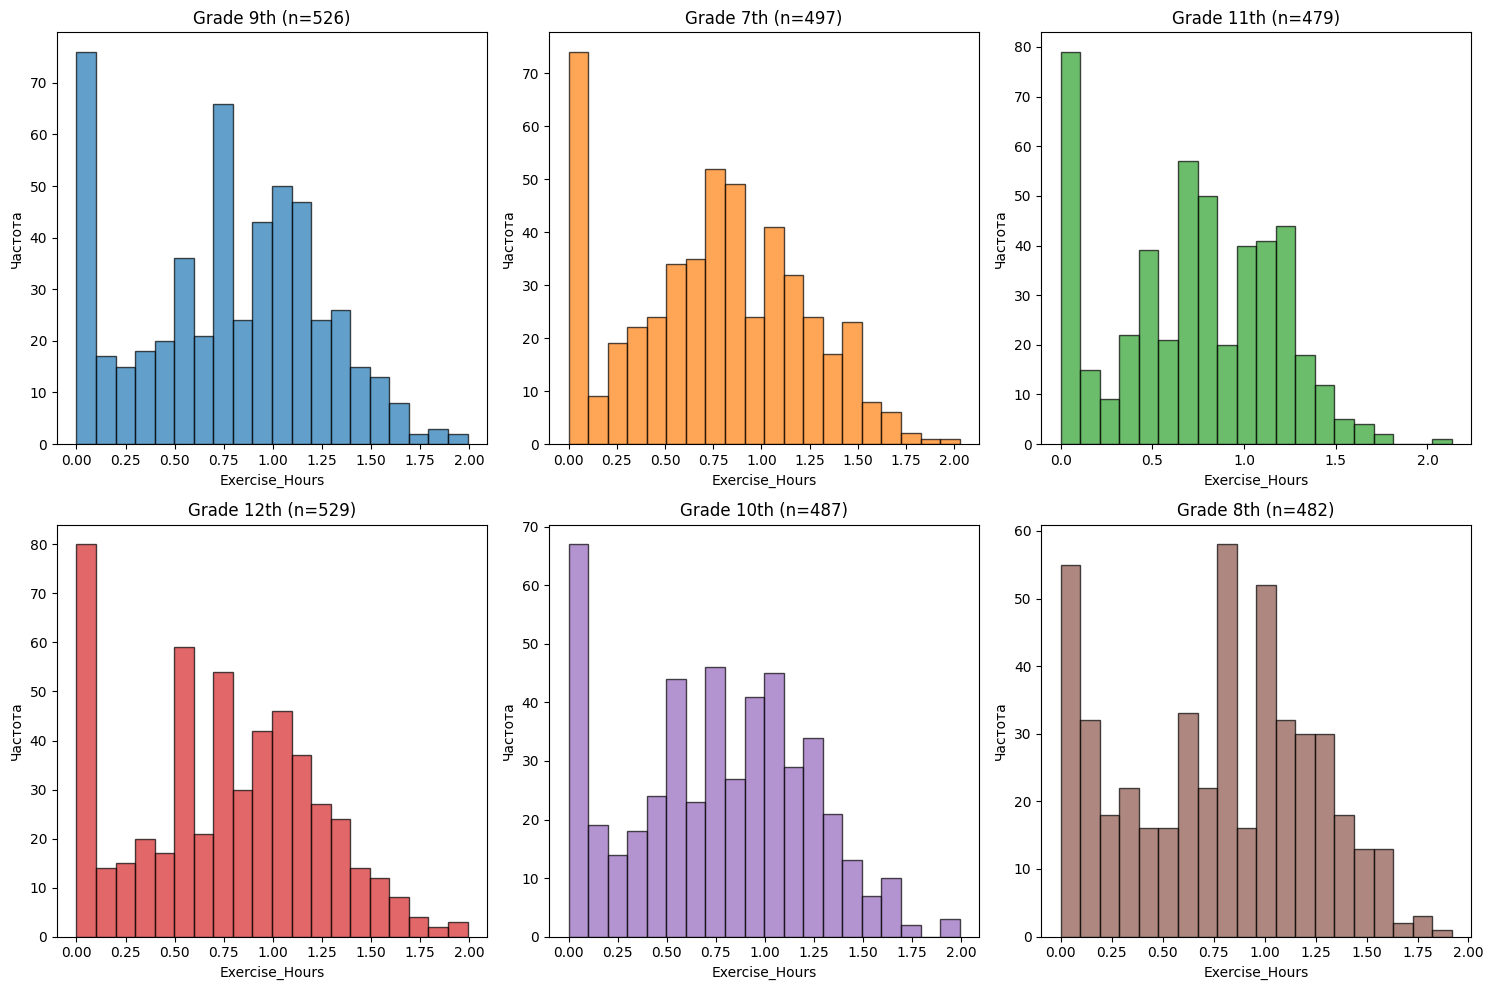


=== СТАТИСТИКА ПО ГРУППАМ (School_Grade) ===
                mean     var  count
School_Grade                       
10th          0.7514  0.2116    487
11th          0.7138  0.2026    479
12th          0.7512  0.2206    529
7th           0.7433  0.2116    497
8th           0.7615  0.2209    482
9th           0.7731  0.2198    526

ANOVA тест: F = 0.9280, p-value = 0.4615
Нет статистически значимых различий между группами


In [12]:
# Добавляем обработанные данные в DataFrame
df_processed = df.copy()
df_processed[f'{selected_col}_processed'] = data_processed

# Группировка по School_Grade
grades = df_processed['School_Grade'].unique()
print(f"Уникальные значения School_Grade: {grades}")

# Построение гистограмм для каждой группы
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, grade in enumerate(grades[:6]):  
    grade_data = df_processed[df_processed['School_Grade'] == grade][f'{selected_col}_processed']
    
    if len(grade_data) > 0:
        axes[i].hist(grade_data, bins=20, alpha=0.7, color=f'C{i}', edgecolor='black')
        axes[i].set_title(f'Grade {grade} (n={len(grade_data)})')
        axes[i].set_xlabel(selected_col)
        axes[i].set_ylabel('Частота')

# Убираем пустые subplots
for i in range(len(grades), 6):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

# Статистика по группам
group_stats = df_processed.groupby('School_Grade')[f'{selected_col}_processed'].agg(['mean', 'var', 'count']).round(4)
print("\n=== СТАТИСТИКА ПО ГРУППАМ (School_Grade) ===")
print(group_stats)

# ANOVA тест для проверки различий между группами
from scipy.stats import f_oneway

groups = [df_processed[df_processed['School_Grade'] == grade][f'{selected_col}_processed'].dropna() 
          for grade in grades if len(df_processed[df_processed['School_Grade'] == grade]) > 10]

if len(groups) >= 2:
    f_stat, p_value = f_oneway(*groups)
    print(f"\nANOVA тест: F = {f_stat:.4f}, p-value = {p_value:.4f}")
    if p_value < 0.05:
        print("Есть статистически значимые различия между группами")
    else:
        print("Нет статистически значимых различий между группами")

In [23]:
print("=== ИТОГОВЫЕ ВЫВОДЫ ===")
print("\n1. ЧИСЛОВЫЕ ХАРАКТЕРИСТИКИ И ГРАФИКИ:")
print(f"   - Распределение {selected_col} имеет асимметрию {skewness_val:.4f} и эксцесс {kurtosis_val:.4f}")
print("   - Гистограмма и ЭФР показывают форму распределения и вероятностные свойства")

print("\n2. НОРМАЛЬНОСТЬ ДАННЫХ:")
print(f"   - Исходные данные: {'нормальные' if is_normal_overall else 'ненормальные'}")
print(f"   - После обработки: {'нормальные' if is_normal_after else 'ненормальные'}")

print("\n3. ЭФФЕКТ ОТ ОБРАБОТКИ ДАННЫХ:")
print(f"   - Лучшее преобразование: {best_transform[0]}")
print(f"   - Асимметрия уменьшилась с {skewness_val:.4f} до {skewness_processed:.4f}")
if is_normal_after and not is_normal_overall:
    print("   - Обработка помогла приблизить распределение к нормальному")
else:
    print("   - Обработка не привела к значительному улучшению нормальности")

print("\n4. РАЗЛИЧИЯ МЕЖДУ ГРУППАМИ School_Grade:")
print("   - Гистограммы показывают различия в распределениях по классам")
print("   - Статистика по группам показывает вариацию средних и дисперсий")
if 'p_value' in locals() and p_value < 0.05:
    print("   - Обнаружены статистически значимые различия между группами")
else:
    print("   - Значимых различий между группами не обнаружено")

print("\n5. РЕКОМЕНДАЦИИ:")
if not is_normal_overall:
    print("   - Для дальнейшего анализа рекомендуется использовать непараметрические методы")
    print("   - Или применять подходящие преобразования данных")
else:
    print("   - Данные можно анализировать с помощью параметрических методов")

=== ИТОГОВЫЕ ВЫВОДЫ ===

1. ЧИСЛОВЫЕ ХАРАКТЕРИСТИКИ И ГРАФИКИ:
   - Распределение Exercise_Hours имеет асимметрию 0.4384 и эксцесс -0.2591
   - Гистограмма и ЭФР показывают форму распределения и вероятностные свойства

2. НОРМАЛЬНОСТЬ ДАННЫХ:
   - Исходные данные: ненормальные
   - После обработки: ненормальные

3. ЭФФЕКТ ОТ ОБРАБОТКИ ДАННЫХ:
   - Лучшее преобразование: Без выбросов
   - Асимметрия уменьшилась с 0.4384 до 0.3185
   - Обработка не привела к значительному улучшению нормальности

4. РАЗЛИЧИЯ МЕЖДУ ГРУППАМИ School_Grade:
   - Гистограммы показывают различия в распределениях по классам
   - Статистика по группам показывает вариацию средних и дисперсий
   - Значимых различий между группами не обнаружено

5. РЕКОМЕНДАЦИИ:
   - Для дальнейшего анализа рекомендуется использовать непараметрические методы
   - Или применять подходящие преобразования данных
